In [2]:
from google.colab import files
uploaded = files.upload()

Saving Intel Image Classification.zip to Intel Image Classification.zip


In [3]:
import zipfile
import os

dataset_path = "/content/Intel Image Classification.zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")


Dataset extracted successfully!


1. Count classes and images per class

In [4]:
dataset_root = "/content/dataset"

train_dir = os.path.join(dataset_root, "seg_train", "seg_train")
test_dir = os.path.join(dataset_root, "seg_test", "seg_test")
pred_dir = '/content/dataset/seg_pred/seg_pred'

print("Train Classes:", os.listdir(train_dir))
print("Test Classes:", os.listdir(test_dir))

for folder in os.listdir(train_dir):
    num_images = len(os.listdir(os.path.join(train_dir, folder)))
    print(f"Class '{folder}': {num_images} train images")


Train Classes: ['glacier', 'sea', 'mountain', 'buildings', 'street', 'forest']
Test Classes: ['glacier', 'sea', 'mountain', 'buildings', 'street', 'forest']
Class 'glacier': 2404 train images
Class 'sea': 2274 train images
Class 'mountain': 2512 train images
Class 'buildings': 2191 train images
Class 'street': 2382 train images
Class 'forest': 2271 train images


2. Count images in the train, test and pred sets

In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load full training dataset
train_data = datasets.ImageFolder(root=train_dir, transform=transform)

# Split into train and validation sets
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Load test set
test_data = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train split: {len(train_dataset)} images")
print(f"Validation split: {len(val_dataset)} images")
print(f"Test set: {len(test_data)} images")


Train split: 11227 images
Validation split: 2807 images
Test set: 3000 images


In [7]:
import os
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.transforms as transforms

class ImageFolderNoClass(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, filename) for filename in os.listdir(root_dir)
                            if os.path.isfile(os.path.join(root_dir, filename))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

pred_data = ImageFolderNoClass(root_dir=pred_dir, transform=transform)
pred_loader = DataLoader(pred_data, batch_size=32, shuffle=False)

print(f"Prediction set: {len(pred_data)} images")


Prediction set: 7301 images


3. Transformation to tensors

In [8]:
augment_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_data_aug = datasets.ImageFolder(root=train_dir, transform=augment_transform)
train_loader_aug = DataLoader(train_data_aug, batch_size=batch_size, shuffle=True)

4. Histogram visualization of the number of the images in the classes in training set

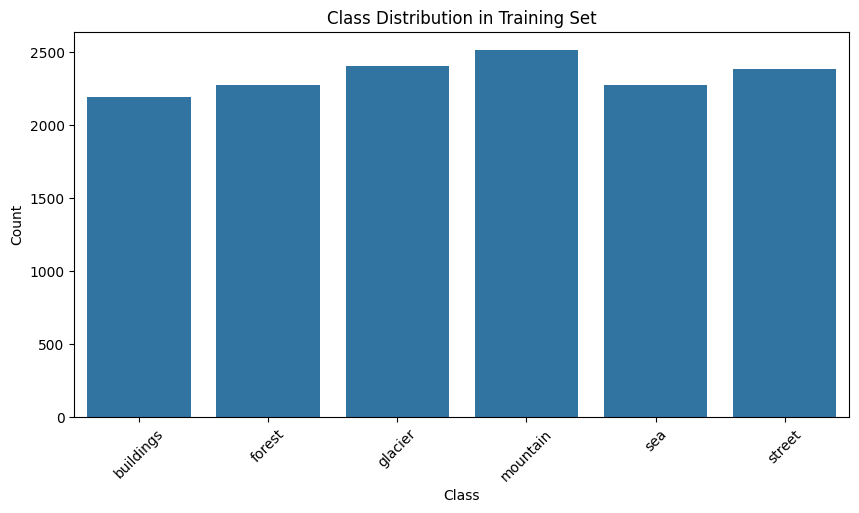

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

class_counts = Counter([train_data.classes[label] for _, label in train_data])
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


5. Visualization of images in classes

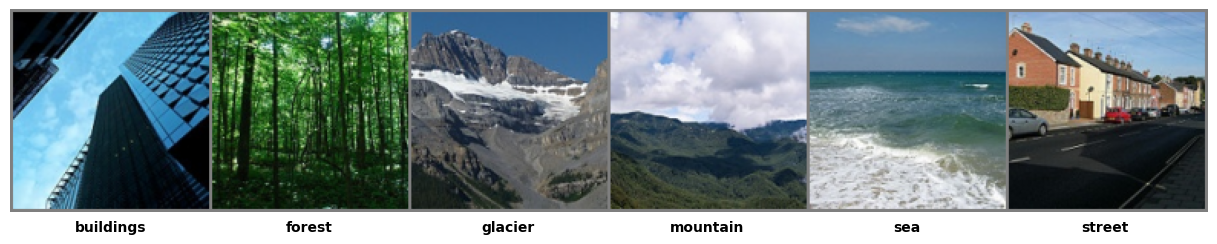

In [18]:
import torchvision
import numpy as np

def imshow_with_labels(images, labels, class_names):
    images = images.cpu()
    images = images / 2 + 0.5
    npimg = images.numpy()

    fig, ax = plt.subplots(figsize=(12, 3))
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis("off")

    num_images = len(labels)
    img_width = npimg.shape[2]
    step = img_width // num_images

    for i, label in enumerate(labels):
        class_name = class_names[label]
        x_pos = step * i + step // 2
        ax.text(x_pos, npimg.shape[1] + 5, class_name, ha='center', va='top',
                fontsize=10, color='black', fontweight="bold")

    plt.tight_layout(pad=0.1)
    plt.show()

def get_one_image_per_class(loader, num_classes):
    class_seen = [False] * num_classes
    images_per_class = [None] * num_classes
    labels_per_class = [None] * num_classes

    for images, labels in loader:
        for img, lbl in zip(images, labels):
            lbl = lbl.item()
            if not class_seen[lbl]:
                class_seen[lbl] = True
                images_per_class[lbl] = img
                labels_per_class[lbl] = lbl
            if all(class_seen):
                return torch.stack(images_per_class), torch.tensor(labels_per_class)
    raise RuntimeError("Not enough classes found in the data.")

images, labels = get_one_image_per_class(train_loader, num_classes=6)
imshow_with_labels(torchvision.utils.make_grid(images, padding=2), labels, train_loader.dataset.dataset.classes)



**Висновок:**

Запропонований датасет збалансований і організований, всі класи мають схожу кількість зображень, вибірка поділяється 1 до 5, як тестові до навчальний данних, що є хорошим співвідношенням.

Також я реалізував попередню обробку зображень, включаючи перетворення до тензорів, нормалізацію, а також аугментацію для підвищення загальної якості навчання. Крім того, розділив навчальну вибірку на навчальну та валідаційну підмножини у співвідношенні 80:20, що дозволяє більш точно оцінювати продуктивність моделі під час тренування.
